# Customer Clustering
Unsupervised ML technique to group our customers (using K-Means). Unlike classification, our examples are unlabeled and we group based on their similiarities. Clustering is descriptive, whereas classification is predictive.

In [1]:
# packages
import pandas as pd
import os
import warnings
from dotenv import load_dotenv
from google.cloud import bigquery
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline

# clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [14]:
warnings.filterwarnings('ignore') 

# retreive data from bigquery

load_dotenv()
GOOGLE_APPLICATION_CREDENTIALS = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')

# Initialize the BigQuery Client
client = bigquery.Client()

# BQ query
sql_query = """
    SELECT 
        * 
    FROM `crudek-data.practice_data.marketing_campaign_clean`             
"""

query_job = client.query(
    sql_query)

# retreive and convert the result to a Pandas DataFrame
df = query_job.to_dataframe()

### Data Preparation
Remeber, a majority of the data preparation work was completed in the *1_data_preparation* notebook within this repo. If needed, go back and familiarize yourself with the following steps that were taken:
1. EDA
2. Handle missing data
3. Handle outliers
4. Create new features
5. Remove certain fields

In [3]:
df.head()

,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,...,Complain,Response,CustomerAge,DaysEnrolled,Income,Relationship,Education,TotalAcceptedCampaigns,TotalAmountSpent,Dependents
0,37.0,39.0,1.0,9.0,2.0,0.0,8.0,0.0,1.0,0.0,...,0.0,0.0,49.0,2402.0,157733.0,current,medium,0.0,59.0,1.0
1,76.0,107.0,2.0,12.0,2.0,2.0,12.0,0.0,0.0,0.0,...,0.0,0.0,63.0,2580.0,6835.0,current,high,0.0,137.0,1.0
2,31.0,85.0,1.0,16.0,2.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,44.0,2403.0,162397.0,current,high,0.0,107.0,2.0
3,2.0,67.0,11.0,26.0,4.0,3.0,262.0,0.0,1.0,0.0,...,0.0,0.0,38.0,2211.0,6560.0,single,medium,0.0,373.0,0.0
4,92.0,81.0,4.0,33.0,5.0,2.0,291.0,0.0,23.0,1.0,...,0.0,0.0,54.0,2216.0,7144.0,single,high,0.0,416.0,2.0


In [4]:
# Reminder of summary statisitics, data types and missing values

# unique values for each column
df_uniq_cols = df.nunique().reset_index()
df_uniq_cols.columns = ['column', 'num_unique']

# summary statistics
df_stats = df.describe().transpose().reset_index()
df_stats.rename(columns={'index': 'column'}, inplace=True)

# data types for each column
df_dtypes = df.dtypes.reset_index()
df_dtypes.columns = ['column', 'data_type']

# missing values for each column
df_nulls = df.isna().sum().reset_index()
df_nulls.columns = ['column', 'num_nulls']

# merge the above together
df_combined = pd.merge(df_uniq_cols, df_dtypes, on='column', how='outer')
df_combined = pd.merge(df_combined, df_nulls, on='column', how='outer')
df_combined = pd.merge(df_combined, df_stats, on='column', how='outer')

# sort by 'num_unique' column
df_sorted = df_combined.sort_values(by='num_unique', ascending=False)

# --------------------------------------------------------------------------------- #

# first 3 values for each col
first_three_df = df.apply(lambda x: pd.Series(x.head(3).values)).reset_index()

# melt to 2 columns
melted_df = first_three_df.melt(var_name='column', value_name='value')

# assign a new column to indicate the value index
melted_df['val_index'] = melted_df.groupby('column').cumcount() + 1

# pivot the melted DataFrame
reshaped_df = melted_df.pivot(index='column', columns='val_index', values='value')

# rename the columns
reshaped_df.columns = ['first_val', 'second_val', 'third_val']

# reset the index to turn 'column' into a regular column
reshaped_df.reset_index(inplace=True)

# --------------------------------------------------------------------------------- #

# final joined df for initial eda
df_investigate = pd.merge(df_sorted, reshaped_df, on='column', how='inner')

df_investigate

,column,num_unique,data_type,num_nulls,count,mean,std,min,25%,50%,75%,max,first_val,second_val,third_val
0,Income,1975,float64,0,2240.0,51940.887018,21403.653309,1730.0,35538.75,51533.0,68179.50,162397.0,157733.0,6835.0,162397.0
1,TotalAmountSpent,1054,float64,0,2240.0,605.798214,602.249288,5.0,68.75,396.0,1045.50,2525.0,59.0,137.0,107.0
2,MntWines,776,float64,0,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0,39.0,107.0,85.0
3,DaysEnrolled,663,float64,0,2240.0,2365.582143,202.122512,2012.0,2192.75,2367.5,2541.00,2711.0,2402.0,2580.0,2403.0
4,MntMeatProducts,558,float64,0,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0,9.0,12.0,16.0
5,MntGoldProds,213,float64,0,2240.0,44.021875,52.167439,0.0,9.00,24.0,56.00,362.0,8.0,12.0,2.0
6,MntFishProducts,182,float64,0,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0,2.0,2.0,2.0
7,MntSweetProducts,177,float64,0,2240.0,27.062946,41.280498,0.0,1.00,8.0,33.00,263.0,0.0,2.0,1.0
8,MntFruits,158,float64,0,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0,1.0,2.0,1.0
9,Recency,100,float64,0,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0,37.0,76.0,31.0


##### Feature Reminder:
```math
TotalAcceptedCampaigns = AcceptedCmp1 + AcceptedCmp2 + AcceptedCmp3 + AcceptedCmp4 + AcceptedCmp5
```
```math
TotalAmountSpent = MntFishProducts + MntMeatProducts + MntFruits + MntSweetProducts + MntWines + MntGoldProds
```
\
*be aware of multicollinearity

In [5]:
df2 = df.copy()

# remove columns due to the above calcs
# df2 = df2.drop(columns=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5', 'MntFishProducts','MntMeatProducts','MntFruits','MntSweetProducts','MntWines','MntGoldProds'])

# manually select some features to try
df2 = df2[['TotalAmountSpent', 'CustomerAge', 'Income', 'Education', 'Recency', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'Relationship']]

df2

,TotalAmountSpent,CustomerAge,Income,Education,Recency,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,Relationship
0,59.0,49.0,157733.0,medium,37.0,1.0,0.0,1.0,0.0,current
1,137.0,63.0,6835.0,high,76.0,0.0,0.0,1.0,0.0,current
2,107.0,44.0,162397.0,high,31.0,0.0,0.0,1.0,0.0,current
3,373.0,38.0,6560.0,medium,2.0,1.0,0.0,1.0,0.0,single
4,416.0,54.0,7144.0,high,92.0,23.0,1.0,1.0,0.0,single
...,...,...,...,...,...,...,...,...,...,...
2235,1795.0,34.0,92910.0,low,42.0,6.0,7.0,13.0,1.0,current
2236,1315.0,44.0,79689.0,medium,65.0,4.0,9.0,13.0,1.0,single
2237,1957.0,65.0,82384.0,medium,55.0,3.0,10.0,13.0,1.0,current
2238,1424.0,72.0,90842.0,low,57.0,4.0,9.0,13.0,1.0,single


### Data Preprocessing
1. **One-hot encoding** to represent *Nominal* categorical variables, with no inherent order, as numerical values for our ML model
2. **Ordinal encoding** to represent *Ordinal* categorical variables, with an inherent order, as numerical values for our ML model
3. **Standard scaler** to scale our numerical values 

In [6]:
df3 = df2.copy()

# categorical variable encoding

# ordinal Encoding for 'Education' with the appropriate order defined
education_order = ['low', 'medium', 'high']

# apply OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[education_order])
df3['Education'] = ordinal_encoder.fit_transform(df3[['Education']])

# One-Hot Encoding for 'Relationship'. Remove drop_first=True
df3 = pd.get_dummies(df3, columns=['Relationship']).astype(int)


# numerical scaling

# select numerical columns
numerical_columns = df3.select_dtypes(include=['number']).columns.tolist()

# initialize the StandardScaler
scaler = StandardScaler()

# fit and transform the numerical columns
df3[numerical_columns] = scaler.fit_transform(df3[numerical_columns])

df3 # scaled data

,TotalAmountSpent,CustomerAge,Income,Education,Recency,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,Relationship_current,Relationship_previous,Relationship_single
0,-0.908129,-0.178492,4.943817,0.385454,-0.418199,-1.110409,-0.910898,-1.473796,-1.203537,0.742460,-0.400026,-0.527076
1,-0.778586,1.018579,-2.107862,1.627781,0.928672,-1.470368,-0.910898,-1.473796,-1.203537,0.742460,-0.400026,-0.527076
2,-0.828410,-0.606017,5.161772,1.627781,-0.625410,-1.470368,-0.910898,-1.473796,-1.203537,0.742460,-0.400026,-0.527076
3,-0.386634,-1.119047,-2.120714,0.385454,-1.626930,-1.110409,-0.910898,-1.473796,-1.203537,-1.346874,-0.400026,1.897258
4,-0.315219,0.249033,-2.093422,1.627781,1.481235,6.808690,-0.568720,-1.473796,-1.203537,-1.346874,-0.400026,1.897258
...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1.975041,-1.461068,1.914545,-0.856873,-0.245523,0.689386,1.484354,2.218248,-0.685887,0.742460,-0.400026,-0.527076
2236,1.177851,-0.606017,1.296709,0.385454,0.548785,-0.030532,2.168711,2.218248,-0.685887,-1.346874,-0.400026,1.897258
2237,2.244093,1.189589,1.422650,0.385454,0.203434,-0.390491,2.510890,2.218248,-0.685887,0.742460,-0.400026,-0.527076
2238,1.358880,1.788124,1.817905,-0.856873,0.272504,-0.030532,2.168711,2.218248,-0.685887,-1.346874,-0.400026,1.897258


### Determine K (# of clusters)

**Inertia** is a metric that measures how well the clusters have been formed by calculating the sum of squared distances between each data point and its assigned cluster center (centroid)

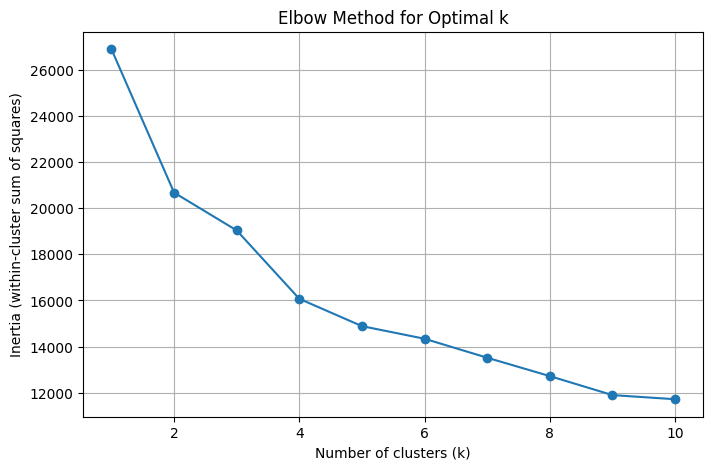

In [7]:
# create a list to store the inertia values
inertia = []

# run K-Means for a range of cluster values and compute the inertia for each
for k in range(1, 11):  # range from 1 to 10 clusters
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(df3)  # fit on our transformed df
    inertia.append(kmeans.inertia_)  # append the inertia to the list

# plot the Elbow Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.grid(True)
plt.show()

### Model & Evaluation

Based on our elbow plot above, it looks like the ideal number of clusters will be somewhere between 3 and 7. We can evaluate the quality of our clusters by calculating the Silhouette Score. This score gives a measure of how well each point is clustered, considering both intra-cluster cohesion and inter-cluster separation. The score ranges from -1 to 1, with higher values indicating better clustering.

In [8]:
# loop through k=3 to k=6 to determine best number of clusters
silhouette_scores = {}

for k in range(3, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df3)
    
    # calculate silhouette score
    sil_score = silhouette_score(df3, cluster_labels)
    silhouette_scores[k] = sil_score

# output all silhouette scores
print("\nSilhouette Scores for different cluster sizes:")
for k, score in silhouette_scores.items():
    print(f'{k} clusters: {score}')


Silhouette Scores for different cluster sizes:
3 clusters: 0.17802971768405584
4 clusters: 0.24412156498037807
5 clusters: 0.2104216321275709
6 clusters: 0.1515798224295066


In [9]:
df4 = df3.copy()

# 3 clusters turned out to be the best based on silhouette scores
final_kmeans = KMeans(n_clusters=4, random_state=42)

# assign cluster labels to the DataFrame
df4['cluster'] = final_kmeans.fit_predict(df4)

# cluster counts
cluster_counts = df4['cluster'].value_counts()
print(cluster_counts)

cluster
2    774
3    692
0    465
1    309
Name: count, dtype: int64


### PCA

Since we have too many features to easily visualize our clusters, we can use Principal Compnent Analysis to compress our features in to a 2D space.

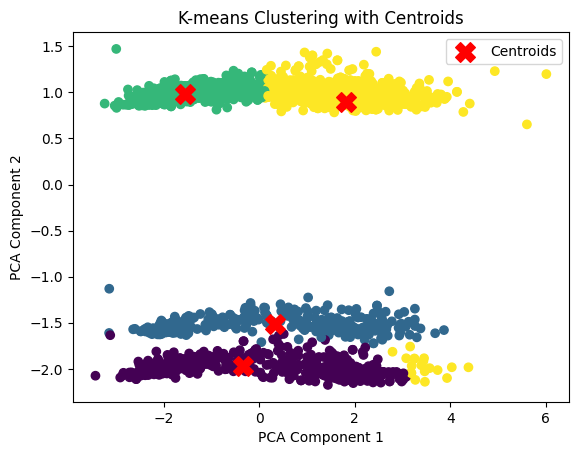

In [10]:
warnings.filterwarnings('ignore')

# apply PCA to reduce data to 2D, drop 'cluster' before performing PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df3)

# find cluster cneters
centroids = final_kmeans.cluster_centers_  
centroids_pca = pca.transform(centroids)  # transform the centroids using PCA

# plot the centroids along with your clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=final_kmeans.labels_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, color='red', label='Centroids')
plt.title('K-means Clustering with Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

### Analysis

Visualize our data with new groupings

In [11]:
df5 = df2.copy()

# add new groups back to original, untransformed data
df5['Cluster'] = final_kmeans.labels_

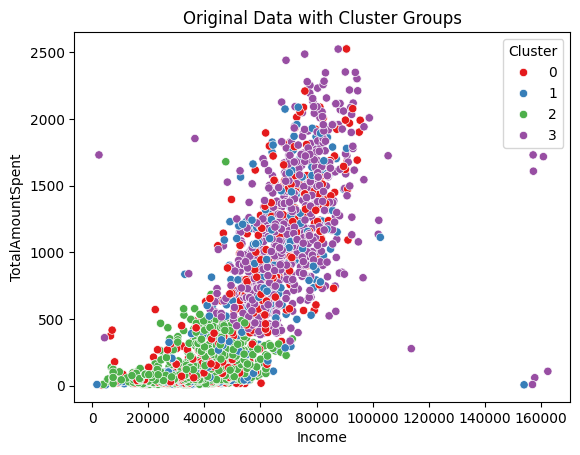

In [12]:
# scatterplot
sns.scatterplot(data=df5, x='Income', y='TotalAmountSpent', hue='Cluster', palette='Set1')
plt.title('Original Data with Cluster Groups')
plt.show()

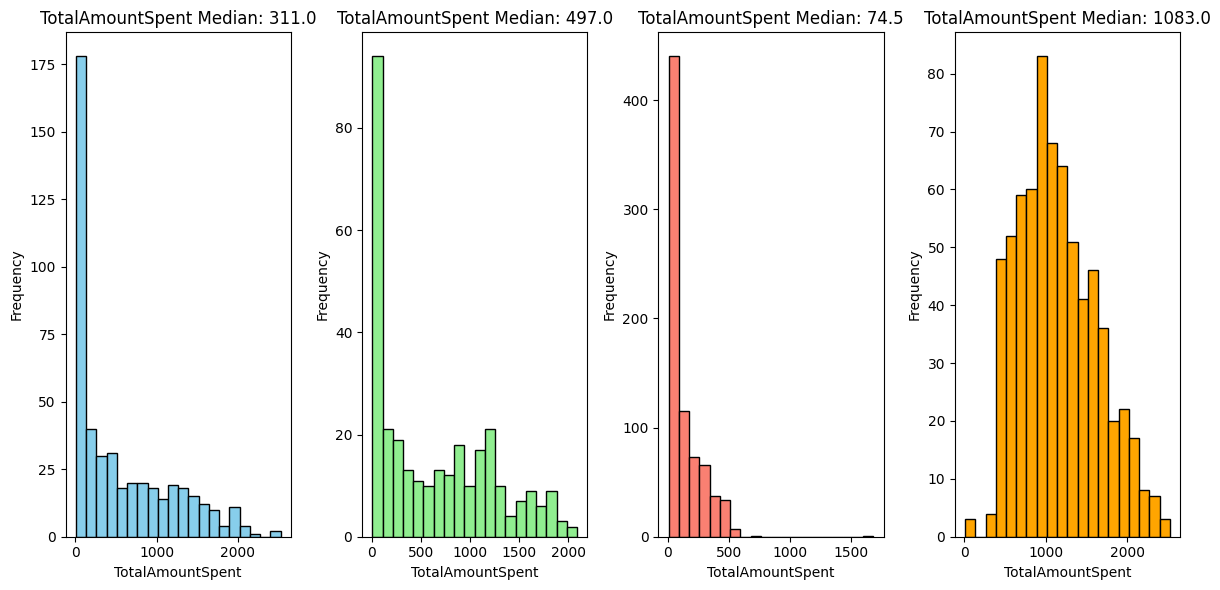

In [13]:
# histograms

# which variable do you want to explore
# manually dynamic
var_explore = 'TotalAmountSpent'

# plot histogram for each cluster
plt.figure(figsize=(12, 6))

# cluster 0
c0 = df5[df5['Cluster'] == 0][var_explore].median()
plt.subplot(1, 4, 1)  # 1 row, 3 columns, position 1
plt.hist(df5[df5['Cluster'] == 0][var_explore], bins=20, color='skyblue', edgecolor='black')
plt.title(f'{var_explore} Median: {c0}')
plt.xlabel(var_explore)
plt.ylabel('Frequency')

# cluster 1
c1 = df5[df5['Cluster'] == 1][var_explore].median()
plt.subplot(1, 4, 2)  # 1 row, 3 columns, position 2
plt.hist(df5[df5['Cluster'] == 1][var_explore], bins=20, color='lightgreen', edgecolor='black')
plt.title(f'{var_explore} Median: {c1}')
plt.xlabel(var_explore)
plt.ylabel('Frequency')

# cluster 2
c2 = df5[df5['Cluster'] == 2][var_explore].median()
plt.subplot(1, 4, 3)  # 1 row, 3 columns, position 3
plt.hist(df5[df5['Cluster'] == 2][var_explore], bins=20, color='salmon', edgecolor='black')
plt.title(f'{var_explore} Median: {c2}')
plt.xlabel(var_explore)
plt.ylabel('Frequency')

# cluster 3
c3 = df5[df5['Cluster'] == 3][var_explore].median()
plt.subplot(1, 4, 4)  # 1 row, 4 columns, position 4
plt.hist(df5[df5['Cluster'] == 3][var_explore], bins=20, color='orange', edgecolor='black')
plt.title(f'{var_explore} Median: {c3}')
plt.xlabel(var_explore)
plt.ylabel('Frequency')

# adjust layout for better spacing
plt.tight_layout()
plt.show()

### Next Steps

Now that we have our customers clustered, we want to be able to leverage the insights gained and take actionable next steps. We can start by further profiling the groups. By analyzing the features of our clusters (income, spend, education, web purchases, etc.), we can more appropriately create profiles for each customer segment. We can assign meaningful labels/names based on what makes those groups unique (i.e. "High Spenders," "Budget-Conscious," or "Occasional Shoppers"). We can then use these profiles to tailor our marketing strategies, make custom product recommendations and optimize pricing strategies, among other things.